In [1]:
!pip install kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl


<h2>Loading <span style='color:green'>Modules</span>:</h2>

In [46]:
#LIBRARIES
import numpy as np
import pandas as pd
import os
PATH = os.getcwd()
print('PRESENT WORKING DIRECTORY:\n',PATH)

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

import sklearn
from tensorflow import keras
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

PRESENT WORKING DIRECTORY:
 /home/rc/project/News_article_sorting


[nltk_data] Downloading package stopwords to /home/rc/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<h2>Gathering Data from <span style='color:blue'>Kaggle</span>:</h2>

In [7]:
%%bash
pip install -q kaggle
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
kaggle competitions download -c learn-ai-bbc

mkdir: cannot create directory ‘/home/rc/.kaggle’: File exists


100%|██████████| 1.85M/1.85M [00:00<00:00, 4.85MB/s]


In [15]:
# RUN THE FOLLOWING COMMAND IN TERMINAL
'''unzip learn-ai-bbc.zip'''


'unzip learn-ai-bbc.zip'

In [17]:
ls

 activate_env.sh                 kaggle.json                  setup.sh
'BBC News Sample Solution.csv'   learn-ai-bbc.zip            'step 1.ipynb'
'BBC News Test.csv'             'News Articles Sorting.pdf'
'BBC News Train.csv'             README.md


In [36]:

TRAIN = pd.read_csv(os.path.join(PATH,'BBC News Train.csv'))
display(TRAIN)
print('='*50)
TEST = pd.read_csv(os.path.join(PATH,'BBC News Test.csv'))
display(TEST)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


<h2>Data from <span style='color:green'>Exploration</span>:</h2>

In [37]:
#CATEGORIES OF NEWS:
print('List of News Categories present:\n\n',TRAIN.Category.unique())

List of News Categories present:

 ['business' 'tech' 'politics' 'sport' 'entertainment']


<AxesSubplot:>

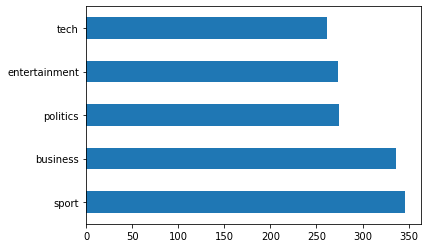

In [38]:
#Count of News Article Present in Train data:
TRAIN['Category'].value_counts().plot.barh()

In [47]:
def preprocessDataset(train_text):
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
    stopwordremove_text = ' '.join(stopwordremove)
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
    stemmer= PorterStemmer()

    stem_input=nltk.word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])   
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = nltk.word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
        
    return lem_text

In [48]:
TRAIN.columns

Index(['ArticleId', 'Text', 'Category'], dtype='object')

In [41]:
X = TRAIN['Text']
y = TRAIN['Category']
X_train, X_val, Y_train, Y_val = train_test_split(X,y,test_size=0.25,shuffle=True,random_state=4)

In [43]:
label = sklearn.preprocessing.LabelEncoder()
label.fit(y)
y_train = label.transform(Y_train)
y_val = label.transform(Y_val)

y_train

array([4, 2, 3, ..., 3, 0, 3])

In [44]:
print(len(X_train),len(y_train))

1117 1117


In [57]:
X_train = X_train.apply(preprocessDataset)
X_val = X_val.apply(preprocessDataset)

In [65]:
tf = TfidfVectorizer()
tf.fit_transform(X_train)

<1117x14240 sparse matrix of type '<class 'numpy.float64'>'
	with 157058 stored elements in Compressed Sparse Row format>

In [69]:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train,y_train)
y_predict = nb.predict(X_val)

train_accuracy = round(nb.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(y_predict, y_val)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(y_predict, y_val))

Naive Bayes Train Accuracy Score : 99% 
Naive Bayes Test Accuracy Score  : 96% 

              precision    recall  f1-score   support

           0       0.98      0.92      0.95        87
           1       0.95      1.00      0.98        63
           2       0.91      0.97      0.94        70
           3       1.00      0.98      0.99        96
           4       0.96      0.95      0.96        57

    accuracy                           0.96       373
   macro avg       0.96      0.96      0.96       373
weighted avg       0.96      0.96      0.96       373



In [71]:
clf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier()),
              ])
clf.fit(X_train,y_train)
y_predict = clf.predict(X_val)

train_accuracy = round(nb.score(X_train,y_train)*100)
test_accuracy =round(accuracy_score(y_predict, y_val)*100)


print("Naive Bayes Train Accuracy Score : {}% ".format(train_accuracy ))
print("Naive Bayes Test Accuracy Score  : {}% ".format(test_accuracy ))
print()
print(classification_report(y_predict, y_val))

Naive Bayes Train Accuracy Score : 99% 
Naive Bayes Test Accuracy Score  : 95% 

              precision    recall  f1-score   support

           0       0.95      0.90      0.92        87
           1       0.97      0.97      0.97        66
           2       0.88      0.96      0.92        69
           3       0.99      0.98      0.98        95
           4       0.93      0.93      0.93        56

    accuracy                           0.95       373
   macro avg       0.94      0.95      0.94       373
weighted avg       0.95      0.95      0.95       373

